In [2]:
from pathlib import Path
import os
import numpy as np
from main import load_data, empirical_iteration, null_iteration
import json
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
from main import prior_from_weights
from joblib import Parallel, delayed
from tqdm import tqdm,trange
from generate_aggregate_figs import load_results,fit_fig,predict,get_priors
from mave_calibration.evidence_thresholds import get_tavtigian_constant
from main import run

/home/dzeiberg/mave_calibration/main.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
kwargs = dict(dataset_dir = Path("/data/dzeiberg/mave_calibration/data/"),
                results_dir = Path("/data/dzeiberg/mave_calibration/results_08_26_24/"),
                debug=True,
                lim=10000,
                dataset_name = "Kato_TP53_AIP1nWT")

In [4]:
dataset_dir = Path(kwargs['dataset_dir'])
results_dir = Path(kwargs['results_dir'])
with open(dataset_dir / "dataset_configs.json",'r') as f:
    dataset_config = json.load(f)
X,S,sample_names, control_sample_index,mu,sigma = load_data(dataset_id=kwargs['dataset_name'],
                                                            data_directory=dataset_dir,
                                                            **dataset_config[kwargs['dataset_name']],
                                                            return_standardization=True)
results = load_results(results_dir,kwargs['dataset_name'],lim=10000)

standardizing to b_lb


10000it [00:03, 2839.83it/s]


In [4]:
# def get_thresholds(priors,quantiles=[.05,.95],posterior=False):
#     # median_prior = np.quantile(priors,0.5)
#     prior_quantiles = np.quantile(priors,quantiles)
#     quantile_pathogenic_thresholds, quantile_benign_thresholds = [],[]
#     for prior_value in prior_quantiles:
#         pathogenic_thresholds_lr,benign_thresholds_lr = thresholds_from_prior(prior_value)
#         if posterior:
#             # P = P * priors / ((P-1) * priors + 1)
#             pathogenic_thresholds = pathogenic_thresholds_lr * prior_value / ((pathogenic_thresholds_lr - 1) * prior_value + 1)
#             benign_thresholds = benign_thresholds_lr * prior_value / ((benign_thresholds_lr - 1) * prior_value + 1)
#         else:
#             pathogenic_thresholds = pathogenic_thresholds_lr
#             benign_thresholds = benign_thresholds_lr
#         quantile_pathogenic_thresholds.append(pathogenic_thresholds)
#         quantile_benign_thresholds.append(benign_thresholds)

#     return quantile_pathogenic_thresholds, quantile_benign_thresholds

def calibration_fig(X, S, sample_names, control_sample_index,dataset_name,results,ax,**kwargs):
    # rng = np.arange((xm // .01) * .01-.01,
    #                 (xM // .01) * .01 + 0.01,
    #                 .01)
    std = X.std()
    rng = np.arange(X.min() - std,X.max() + std,.01)
    priors = np.array(get_priors(results, control_sample_index)).reshape((-1,1))
    label = f"prior={np.nanquantile(priors,.5):.3f}"
    LR = predict(rng,control_sample_index,results,posterior=kwargs.get('posterior',False),priors=priors,return_all=True)
    LR_quantiles = np.nanquantile(LR,[0.05,.5,0.95],axis=0)
    # ax.plot(rng,LR_quantiles[1],color='black',label=label)
    for c,color,label in zip([0,-1],['maroon','cyan'],["5%","95%"]):
        ax.plot(rng,LR_quantiles[c],color=color,ls="-",label=label)
    if not kwargs.get('posterior',False):
        ax.set_yscale('log')
    ax.set_xlabel("Assay Score")
    if not kwargs.get('posterior',False):
        ax.set_ylabel(r"$LR^+$")
    else:
        ax.set_ylabel(r"Posterior Probability Pathogenic")
    quantile_pathogenic_thresholds, quantile_benign_thresholds = get_thresholds(priors,**kwargs)
    pathogenic_thresholds = np.stack(quantile_pathogenic_thresholds)
    benign_thresholds = np.stack(quantile_benign_thresholds)
    score_thresholds = np.ones([2,4]) * np.nan
    for strengthNum,((low,high),linestyle) in enumerate(zip(pathogenic_thresholds.T,["-","-.","--",":"])):
        label=""
        if strengthNum == 0:
            label= f"Prior Range: {np.nanquantile(priors,.05):.3f}-{np.nanquantile(priors,.95):.3f}"
        ax.fill_between(rng,low,high,alpha=.5,linestyle=linestyle,color='r',label=label)
        exceed = np.where(LR_quantiles[0] > low)[0]
        if len(exceed) == 0:
            score_thresholds[0,strengthNum] = np.nan
        else:
            score_thresholds[0,strengthNum] = rng[max(exceed)]
    for strengthNum,((low,high),linestyle) in enumerate(zip(benign_thresholds.T,["-","-.","--",":"])):
        ax.fill_between(rng,low,high,alpha=.5,linestyle=linestyle,color='b')
        exceed = np.where(LR_quantiles[-1] < high)[0]
        if len(exceed) == 0:
            score_thresholds[1,strengthNum] = np.nan
        else:
            score_thresholds[1,strengthNum] = rng[min(exceed)]
    if not kwargs.get('posterior',False):
        ax.set_ylim(benign_thresholds[0,0] * 1e-2,pathogenic_thresholds[1,0] * 1e2)
    else:
        ax.set_ylim(-.01,1.01)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # return score_thresholds
    return dict(p_lp=dict(zip(["Very Strong","Strong","Moderate","Supporting"],score_thresholds[0])),
                b_lb=dict(zip(["Very Strong","Strong","Moderate","Supporting"],score_thresholds[1])))


In [6]:
def thresholds_from_prior(prior, point_values=[1,2,3,4,8]):
    exp_vals = 1 / np.array(point_values).astype(float)
    C = get_tavtigian_constant(prior)
    pathogenic_evidence_thresholds = np.ones(len(point_values)) * np.nan
    benign_evidence_thresholds = np.ones(len(point_values)) * np.nan
    for strength_idx, exp_val in enumerate(exp_vals):
        pathogenic_evidence_thresholds[strength_idx] = C ** exp_val
        benign_evidence_thresholds[strength_idx] = C ** -exp_val
    return pathogenic_evidence_thresholds[::-1], benign_evidence_thresholds[::-1]

def get_score_thresholds(LR,prior):
    lr_thresholds_pathogenic , lr_thresholds_benign = thresholds_from_prior(prior=prior)
    pathogenic_score_thresholds = np.ones(len(lr_thresholds_pathogenic)) * np.nan
    benign_score_thresholds = np.ones(len(lr_thresholds_benign)) * np.nan
    for strength_idx,lr_threshold in enumerate(lr_thresholds_pathogenic):
        exceed = np.where(LR > lr_threshold)[0]
        if len(exceed):
            pathogenic_score_thresholds[strength_idx] = rng[max(exceed)]
    for strength_idx,lr_threshold in enumerate(lr_thresholds_benign):
        exceed = np.where(LR < lr_threshold)[0]
        if len(exceed):
            benign_score_thresholds[strength_idx] = rng[min(exceed)]
    return pathogenic_score_thresholds,benign_score_thresholds

In [6]:
def get_score_threshold_mats(X,control_sample_index,results):
    """
    Calculate the score thresholds corresponding to each evidence strength for each bootstrap iteration

    Parameters
    ----------
    X : np.ndarray
        The assay scores
    control_sample_index : np.ndarray
        The indices of the control samples (usually 1 for B/LB or 4 for synonymous)
    results : list of dict
        Results from the bootstrap iterations

    Returns
    -------
    p_score_thresholds : np.ndarray (n_bootstrap, 5)
        score thresholds for +1, +2, +3, +4, +8 points for each bootstrap iteration

    b_score_thresholds : np.ndarray (n_bootstrap, 5)
        score thresholds for -1, -2, -3, -4, -8 points for each bootstrap iteration
    """
    std = X.std()
    rng = np.arange(X.min() - std,X.max() + std,.01)
    LR_curves = predict(rng,control_sample_index,results,posterior=False,return_all=True)
    priors = np.array(get_priors(results, control_sample_index))
    thresholds_results = Parallel(n_jobs=-1,verbose=10)(delayed(get_score_thresholds)(LR,prior) for LR,prior in list(zip(LR_curves,priors)))
    p_score_thresholds,b_score_thresholds = zip(*thresholds_results)
    p_score_thresholds = np.stack(p_score_thresholds)
    b_score_thresholds = np.stack(b_score_thresholds)
    return p_score_thresholds,b_score_thresholds

In [9]:
# std = X.std()
# rng = np.arange(X.min() - std,X.max() + std,.01)
# LR_curves = predict(rng,control_sample_index,results,posterior=False,return_all=True)
# priors = np.array(get_priors(results, control_sample_index))
# thresholds_results = Parallel(n_jobs=-1,verbose=10)(delayed(get_score_thresholds)(LR,prior) for LR,prior in list(zip(LR_curves,priors)))
# p_score_thresholds,b_score_thresholds = zip(*thresholds_results)
# p_score_thresholds = np.stack(p_score_thresholds)
# b_score_thresholds = np.stack(b_score_thresholds)


# p_score_thresholds,b_score_thresholds,priors = get_score_threshold_mats(X,control_sample_index,results)
import joblib
p_score_thresholds, b_score_thresholds, priors = joblib.load(f"/data/dzeiberg/mave_calibration/results_08_26_24/figs3/{kwargs['dataset_name']}_score_thresholds.pkl")
p_score_thresholds = np.array(p_score_thresholds)
b_score_thresholds = np.array(b_score_thresholds)
priors = np.array(priors)


In [ ]:
np.nanquantile(p_score_thresholds,.95,axis=0)

In [ ]:
np.nanquantile(b_score_thresholds,.95,axis=0)

In [21]:
def summarize_thresholds(score_thresholds,q):
    accept = (np.isnan(score_thresholds).sum(axis=0) / len(score_thresholds)) < .05
    score_thresholds = np.nanquantile(score_thresholds,q=q,axis=0)
    score_thresholds[~accept] = np.nan
    return score_thresholds

In [28]:
from generate_aggregate_figs import get_sample_density
def fit_fig_scaled(X,S,sample_names,dataset_name,results,ax, priors, mu=0,sigma=1):
    N_Samples = S.shape[1]
    std=X.std()
    rng = np.arange(X.min() - std,X.max() + std,.01)
    palette = sns.color_palette("pastel", N_Samples)
    palette_3 = sns.color_palette("dark", N_Samples)
    palette_2 = sns.color_palette("bright", N_Samples)
    D = get_sample_density(rng, results)
    sample_name_map = dict(p_lp="P/LP", b_lb="B/LB", gnomad="gnomAD", vus="VUS", synonymous="Synonymous",nonsynonymous="Nonsynonymous")
    XRaw = (sigma * X) + mu
    # bins = np.linspace(XRaw.min(),XRaw.max(),25)
    for i in range(N_Samples):
        name = sample_name_map[sample_names[i]]
        label = f"{name} (n={S[:,i].sum():,d})"
        if name == "gnomAD":
            label += f" (median prior={np.quantile(priors,.5):.2f})"
        sns.histplot(XRaw[S[:,i]],ax=ax[i],stat='density',color=palette[i],label=label)
        ax[i].plot((sigma * rng) + mu, D[i].mean(0),color=palette_3[i],)
        q = np.nanquantile(D[i], [0.025, .975], axis=0)
        ax[i].fill_between((sigma * rng) + mu, q[0], q[1], alpha=.5, color=palette_2[i])
        ax[i].legend()

z = (x - mu) / sigma

x = (z * sigma) + mu

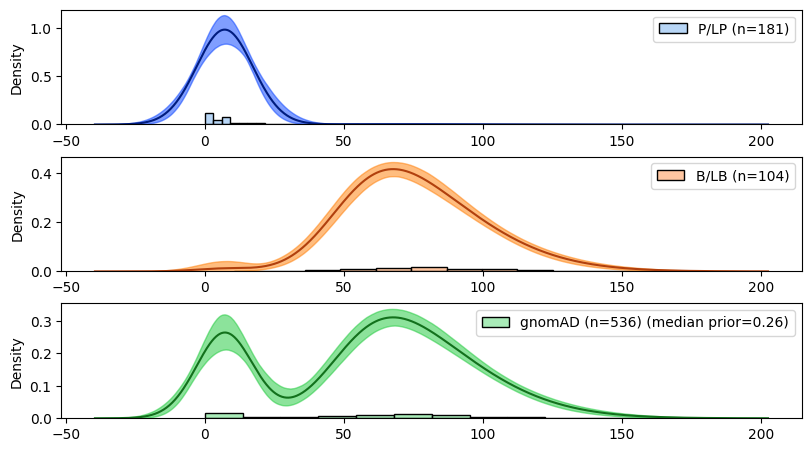

In [29]:
NSamples = S.shape[1]
fig = plt.figure(layout="constrained", figsize=(8,(NSamples) * 3))

gs = GridSpec(NSamples + 4, 1, figure=fig,)
topAxs = [fig.add_subplot(gs[i, 0]) for i in range(NSamples)]

fit_fig_scaled(X,S,sample_names,kwargs['dataset_name'],results,topAxs,priors,mu=mu,sigma=sigma)


# linestyles = [(0, (1,5)),'dotted','dashed','dashdot','solid']
# for s,linestyle in zip(summarize_thresholds(p_score_thresholds,.05),linestyles):
#     if np.isnan(s):
#         continue
#     for axi in topAxs:
#         axi.axvline(s,color='r',linestyle=linestyle)
# for s,linestyle in zip(summarize_thresholds(b_score_thresholds,.95),linestyles):
#     if np.isnan(s):
#         continue
#     for axi in topAxs:
#         axi.axvline(s,color='b',linestyle=linestyle)

# ymax = float(max([axi.get_ylim()[1] for axi in topAxs]))
# for axi in topAxs:
#     axi.set_ylim(0,ymax)

(array([90., 55., 14., 14.,  3.,  1.,  2.,  1.,  0.,  1.]),
 array([ 0.  ,  5.53, 11.06, 16.59, 22.12, 27.65, 33.18, 38.71, 44.24,
        49.77, 55.3 ]),
 <BarContainer object of 10 artists>)

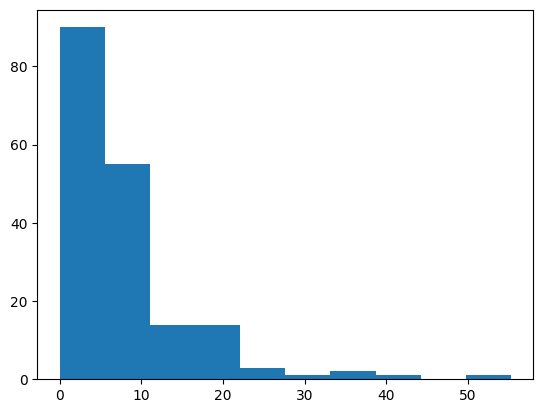

In [23]:
plt.hist(X[S[:,0]] * sigma + mu)

In [ ]:
fig.savefig(f"/data/dzeiberg/mave_calibration/results_08_26_24/figs/{kwargs['dataset_name']}.jpeg",
            format='jpeg',
            bbox_inches='tight',
            dpi=300)

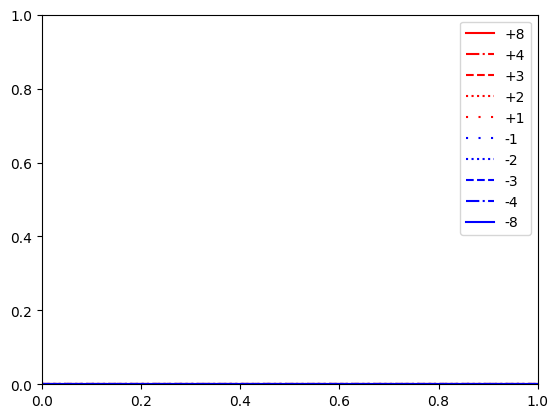

In [7]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
linestyles = [(0, (1,5)),'dotted','dashed','dashdot','solid']
labels = ['+1','+2','+3','+4','+8']
for l,ls in list(zip(labels,linestyles))[::-1]:
    ax.axhline(linestyle=ls,label=l,color='red')
labels = ['-1','-2','-3','-4','-8']
for l,ls in list(zip(labels,linestyles)):
    ax.axhline(linestyle=ls,label=l,color='blue')
ax.legend()
fig.savefig("/data/dzeiberg/mave_calibration/legend.jpeg",format='jpeg',bbox_inches='tight',dpi=1000)

In [4]:
from generate_aggregate_figs import get_sample_density

In [5]:
std = X.std()
rng = np.arange(X.min() - std,X.max() + std,.01)

In [6]:
D = get_sample_density(rng, results)

In [7]:
D.shape

(3, 10001, 1603)

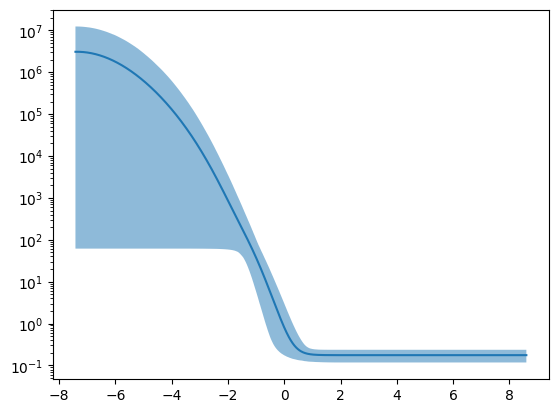

In [10]:
plt.plot(rng, (D[0] / D[1]).mean(axis=0))
plt.fill_between(rng, *np.quantile(D[0] / D[1],[.05,.95],axis=0),alpha=.5)
plt.yscale('log')

In [11]:
from mave_calibration.evidence_thresholds import get_tavtigian_constant
from generate_aggregate_figs import get_priors

(array([ 54.,   7.,  11.,  12.,  14.,  17.,  14.,  21.,  26.,  37.,  30.,
         28.,  42.,  43.,  49.,  57.,  62.,  55.,  71.,  88.,  98., 118.,
        121., 105., 149., 137., 159., 148., 180., 188., 207., 215., 225.,
        232., 240., 237., 265., 295., 281., 301., 281., 249., 318., 268.,
        268., 237., 235., 223., 231., 216., 211., 205., 188., 179., 188.,
        165., 145., 140., 137., 128., 110., 100., 106.,  98.,  89.,  79.,
         60.,  64.,  67.,  71.,  43.,  36.,  25.,  26.,  22.,  21.,  23.,
         17.,  13.,  23.,  14.,   5.,   6.,   7.,   6.,   3.,   3.,   2.,
          2.,   1.,   1.,   0.,   2.,   4.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([1.00000000e-10, 5.86381642e-04, 1.17276318e-03, 1.75914472e-03,
        2.34552627e-03, 2.93190781e-03, 3.51828935e-03, 4.10467089e-03,
        4.69105243e-03, 5.27743397e-03, 5.86381552e-03, 6.45019706e-03,
        7.03657860e-03, 7.62296014e-03, 8.20934168e-03, 8.79572322e-03,
        9.38210476e-03, 9.9684

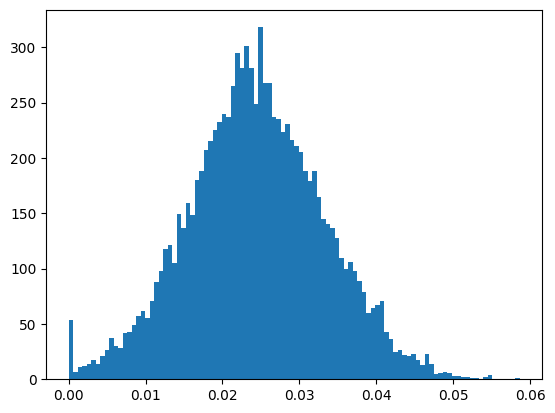

In [12]:
plt.hist(get_priors(results, control_sample_index),bins=100)

In [13]:
get_tavtigian_constant(.025)

np.int64(2458)

In [17]:
D.shape

(3, 10001, 1603)

In [21]:
np.argmin(np.abs(rng - 4))

np.int64(1142)

In [22]:
(D[0,:, 1142] / D[1,:, 1142]).mean(axis=0) 

np.float64(0.1761873634595501)